In [77]:
%matplotlib inline
import pandas as pd
import pandas.io.data
import math
import matplotlib.pyplot as plt
import os

import seaborn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV



In [78]:
class DataHandler:
    def __init__(self):
        pass

    def fetch_data_from_yahoo(self, symbol, start, end):
        df =  pandas.io.data.get_data_yahoo(symbol, start, end)
        return df

    def fetch_and_save_data(self, symbols, names, start, end):
        ret_df=[]
        for symbol, name in zip(symbols, names):
            file_name='./Data/'+name+'_'+start+'_'+end+'.csv'
            if os.path.exists(file_name):
                #print('[INFO] File(',file_name,') Exists locally')
                df=pd.read_csv(file_name, index_col=0, parse_dates=True)
                ret_df.append(df)
            else:
                df=self.fetch_data_from_yahoo(symbol, start, end)
                df.to_csv(file_name,mode='w')
                ret_df.append(df)
        return ret_df

    def load_data(self, symbols, names, start, end):
        ret_df=[]
        for symbol, name in zip(symbols, names):
            df=pd.read_csv('./Data/'+name+'_'+start+'_'+end+'.csv', index_col=0, parse_dates=True)
            ret_df.append(df)
        return ret_df

    def daily_return(self, data_set):
        data_set['Daily Return'] = data_set['Adj Close'].pct_change()
        return data_set

    def plot_data(self, data_frames, names, subplot=False, market_names=[]):
        row = math.ceil((len(data_frames)*1.0)/2)
        if subplot:
            plt.figure((1), figsize=(80,30))
        i=1
        for market_name, data_frame in zip(market_names, data_frames):
            if subplot:
                plt.subplot(row, 2, i)
            if(len(names)==1):
                data_frame[names].plot(ax=plt.gca())
            else:
                df=[]
                for name in names:
                    df.append(data_frame[name])
                d = pd.concat(df, axis=1)
                d.plot()
                plt.title(name+' For '+market_name.upper())
                plt.legend(loc='best')
            i += 1


In [79]:
class DataProcessor:
    def __init__(self):
        pass

    def get_moving_average(self, data_frame, intervals):
        for interval in intervals:
            data_frame['MA_' + str(interval)] = pd.rolling_mean(data_frame['Adj Close'], interval)
        return data_frame

    def get_ewma(self, data_frame, intervals):
        for interval in intervals:
            data_frame['EMA_' + str(interval)] = pd.ewma(data_frame['Adj Close'], span=interval)
        return data_frame

    def prepare_data_for_classification(self, data_set, start_test):
        le = preprocessing.LabelEncoder()
        data_set['UpDown'] = data_set['Daily Return_nse']

        data_set.UpDown[data_set['Daily Return_nse'] >= 0] = 1
        data_set.UpDown[data_set['Daily Return_nse'] < 0] = -1

        data_set['UpDown'].fillna(1, inplace=True)
        #data_set.UpDown = le.fit(data_set.UpDown).transform(data_set.UpDown)
        features = data_set.columns[1:-1]

        X = data_set[features]
        y = data_set.UpDown

        X_train = X[X.index < start_test]
        y_train = y[y.index < start_test]

        X_test = X[X.index >= start_test]
        y_test = y[y.index >= start_test]

        return X_train, y_train, X_test, y_test

    def partition_data(self, data_set, count):
        le = preprocessing.LabelEncoder()
        data_set['UpDown'] = data_set['Daily Return_nse']

        data_set.UpDown[data_set['Daily Return_nse'] >= 0] = 1
        data_set.UpDown[data_set['Daily Return_nse'] < 0] = -1

        data_set['UpDown'].fillna(1, inplace=True)
        #data_set.UpDown = le.fit(data_set.UpDown).transform(data_set.UpDown)
        features = data_set.columns[1:-1]

        X = data_set[features]
        y = data_set.UpDown

        X_train = X[:len(data_set)-count]
        y_train = y[:len(data_set)-count]

        X_test = X[len(data_set)-count:]
        y_test = y[len(data_set)-count:]

        return X_train, y_train, X_test, y_test

    def apply_logistic_regressor(self, X_train, y_train, X_test, y_test, C=1):
        clf = LogisticRegression(C=C)
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        print("Accuracy for Logistic Classifier %s" % accuracy)
        return accuracy


    def apply_svc(self, X_train, y_train, X_test, y_test, kernel='linear', C=1):
        clf = SVC(kernel=kernel, C=C)
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        print("Accuracy for SVM Classifier %s" % accuracy)
        return accuracy

    def apply_knn(self, X_train, y_train, X_test, y_test):
        clf = neighbors.KNeighborsClassifier()
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        print("Accuracy for KNN Classifier %s" % accuracy)
        return accuracy

    def apply_random_forest(self, X_train, y_train, X_test, y_test):
        clf = RandomForestClassifier(n_estimators=5, n_jobs=-1)
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_test, y_test)
        print("Accuracy for RF Classifier %s" % accuracy)
        return accuracy

    def select_best_param_svc(self, X_train, y_train, parameters):
        svr = SVC()
        clf = GridSearchCV(svr, parameters)
        clf.fit(X_train, y_train)
        print("Best Parameter SVC", clf.best_params_)
        return clf.best_params_

    def get_svc_prediction(self, X_train, y_train, x_predict, kernel='linear', C=1):
        clf = SVC(kernel=kernel, C=C)
        clf.fit(X_train, y_train)
        return clf.predict(x_predict)

    def get_randomforest_prediction(self, X_train, y_train, x_predict, n_estimators=5, n_jobs=-1):
        clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_estimators)
        clf.fit(X_train, y_train)
        return clf.predict(x_predict)

    def get_logistic_reg_prediction(self, X_train, y_train, x_predict):
        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        return clf.predict(x_predict)


In [80]:
def plot(data_frames, s='', title=''):
    for data_frame in data_frames:
        data_frame[s].plot()
        plt.ylabel(s)
        plt.xlabel('Date')
        plt.title(s + ' For ' + title)
        plt.grid(True)
        plt.show()


def concat(a, b):
    return a+b

def renamme_columns(data_frames, market_names):
    for market_name,data_frame in zip(market_names, data_frames):
        columns = data_frame.columns
        data_frame.rename(columns=lambda x: concat(x, '_'+market_name), inplace=True)

# def merge_data_frames(data_frames, index):
#     return pd.concat([data_frame.ix[:, index:] for data_frame in data_frames], axis=1)

def merge_data_frames(data_frames, index):
    keys=[]
    for data_frame in data_frames:
        keys.extend(data_frame.ix[:, index:].columns.values.tolist())
    #print("Keys ======== (((( ",keys," )))) ===========")
    #return pd.concat(data_frames, axis=0, keys=keys)
    return pd.concat([data_frame.ix[:, index:] for data_frame in data_frames], axis=1)


def count_missing(dataframe):
    return (dataframe.shape[0] * dataframe.shape[1]) - dataframe.count().sum()



In [81]:
class MarketIntradayPortfolio:
    def __init__(self, symbol, bars, signals, initial_capital=1000000.0, shares=500):
        self.symbol = symbol
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.shares = int(shares)
        self.positions = self.generate_positions()

    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index)
        positions[self.symbol] = self.shares*self.signals['signal']
        return positions

    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()
        portfolio['price_diff'] = self.bars['Adj Close']-self.bars['Open']
        #portfolio['price_diff'][0:2] = 0.0
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']
        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio



In [82]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def get_date(dat, end_date_intervel, start_date_intervel):
    e = (datetime.strptime(dat, '%Y-%m-%d')+ relativedelta(days=end_date_intervel)).strftime('%Y-%m-%d')
    s = (datetime.strptime(dat, '%Y-%m-%d')+ relativedelta(days=start_date_intervel)).strftime('%Y-%m-%d')
    return  e, s


In [83]:
start_date_list = ['2014-01-01', '2012-01-01', '2013-05-01', '2015-07-01', '2010-02-01', '2011-11-15', '2015-02-01','2015-05-01','2015-06-01','2015-07-01', '2015-08-01']
end_date_list   = [450, 60, 60, 90, 75, 90, 60, 60, 60, 60, 60]
start_test_list = [330, 45, 45, 75, 60, 80, 50, 45, 45, 45, 45]

indices = ['^NSEI', '^BSESN', '^AXJO', '^HSI', '^N225']
market_name = ['nse', 'bse', 'aus', 'hsi', 'nikkei']


Shape of merged data (322, 40) .
After merge out of [ 12880 ] [ 688 ] data points are missing.
Number of NaN after time interpolation: 128
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
 1    142
-1     94
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
-1    43
 1    43
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.872093023256
Accuracy for SVM Classifier 0.744186046512
Accuracy for KNN Classifier 0.53488372093
Accuracy for RF Classifier 1.0
Best Parameter SVC {'C': 10, 'kernel': 'linear'}
Accuracy for SVM Classifier 0.5
Accuracy for SVM Classifier 0.744186046512
Benchmark Return [-1.80]%
LR        Return [78.00]%
SVC       Return [-6.27]%
RF        Return [58.53]%


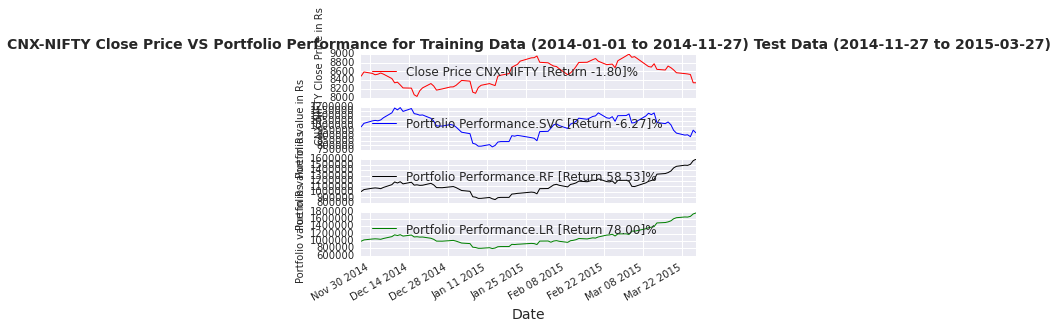

Shape of merged data (44, 40) .
After merge out of [ 1760 ] [ 184 ] data points are missing.
Number of NaN after time interpolation: 123
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
 1    24
-1     8
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
-1    6
 1    6
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.5
Accuracy for SVM Classifier 0.5
Accuracy for KNN Classifier 0.5
Accuracy for RF Classifier 1.0
Best Parameter SVC {'C': 1, 'kernel': 'linear'}
Accuracy for SVM Classifier 0.5
Accuracy for SVM Classifier 0.5
Benchmark Return [-3.47]%
LR        Return [-13.78]%
SVC       Return [-13.78]%
RF        Return [21.93]%


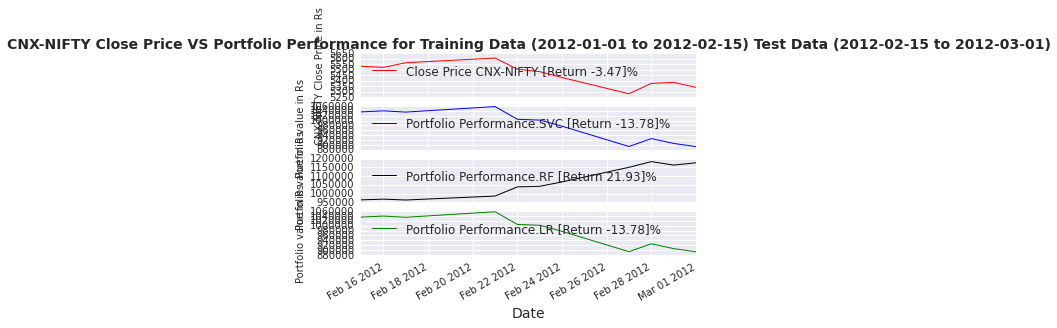

Shape of merged data (43, 40) .
After merge out of [ 1720 ] [ 120 ] data points are missing.
Number of NaN after time interpolation: 94
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
-1    18
 1    15
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
 1    6
-1    4
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.4
Accuracy for SVM Classifier 0.4
Accuracy for KNN Classifier 0.4
Accuracy for RF Classifier 1.0
Best Parameter SVC {'C': 1, 'kernel': 'linear'}
Accuracy for SVM Classifier 0.4
Accuracy for SVM Classifier 0.4
Benchmark Return [-0.13]%
LR        Return [-0.02]%
SVC       Return [-0.02]%
RF        Return [28.66]%


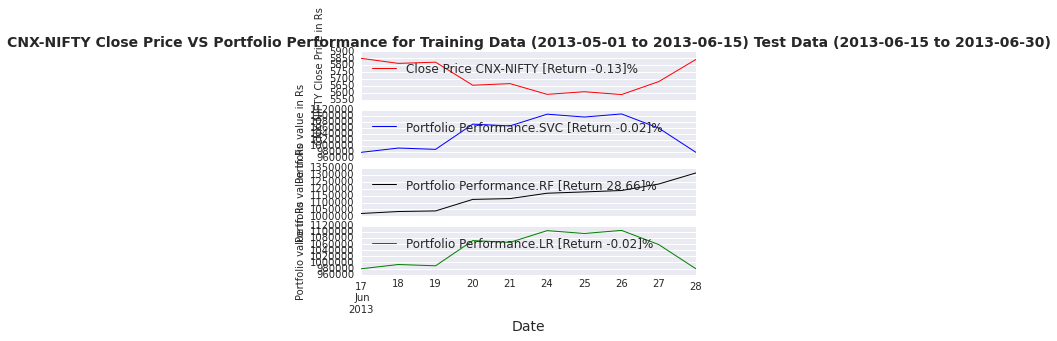

Shape of merged data (65, 40) .
After merge out of [ 2600 ] [ 168 ] data points are missing.
Number of NaN after time interpolation: 88
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
-1    29
 1    24
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
 1    7
-1    5
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.666666666667
Accuracy for SVM Classifier 0.583333333333
Accuracy for KNN Classifier 0.666666666667
Accuracy for RF Classifier 1.0
Best Parameter SVC {'C': 1, 'kernel': 'linear'}
Accuracy for SVM Classifier 0.416666666667
Accuracy for SVM Classifier 0.583333333333
Benchmark Return [-0.37]%
LR        Return [0.73]%
SVC       Return [0.73]%
RF        Return [-0.76]%


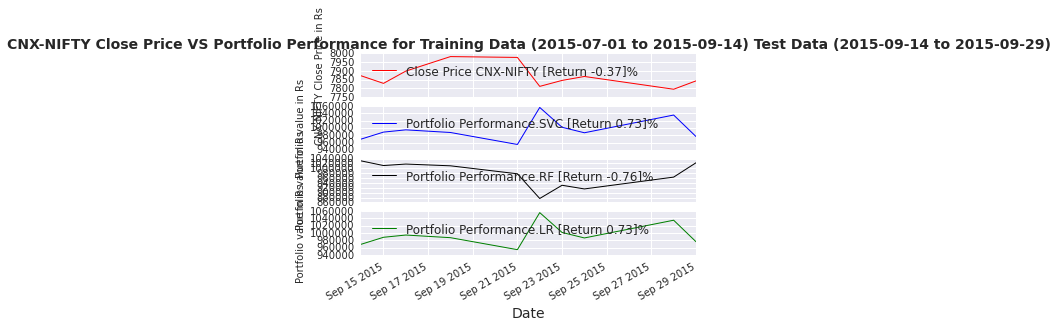

Shape of merged data (55, 40) .
After merge out of [ 2200 ] [ 216 ] data points are missing.
Number of NaN after time interpolation: 80
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
 1    30
-1    14
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
-1    7
 1    4
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.818181818182
Accuracy for SVM Classifier 0.454545454545
Accuracy for KNN Classifier 0.363636363636
Accuracy for RF Classifier 0.909090909091
Best Parameter SVC {'C': 1, 'kernel': 'linear'}
Accuracy for SVM Classifier 0.363636363636
Accuracy for SVM Classifier 0.454545454545
Benchmark Return [-1.97]%
LR        Return [5.20]%
SVC       Return [-7.82]%
RF        Return [-2.45]%


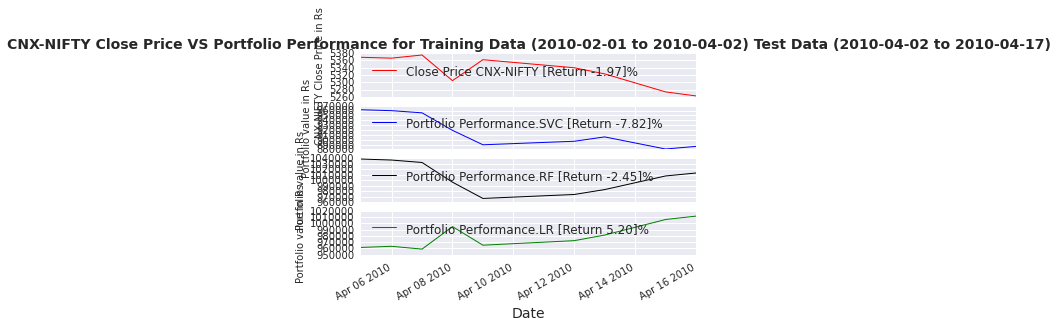

Shape of merged data (65, 40) .
After merge out of [ 2600 ] [ 232 ] data points are missing.
Number of NaN after time interpolation: 82
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
 1    32
-1    26
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
 1    5
-1    2
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.857142857143
Accuracy for SVM Classifier 0.714285714286
Accuracy for KNN Classifier 0.714285714286
Accuracy for RF Classifier 1.0
Best Parameter SVC {'C': 1, 'kernel': 'linear'}
Accuracy for SVM Classifier 0.714285714286
Accuracy for SVM Classifier 0.714285714286
Benchmark Return [1.21]%
LR        Return [6.40]%
SVC       Return [-0.59]%
RF        Return [8.78]%


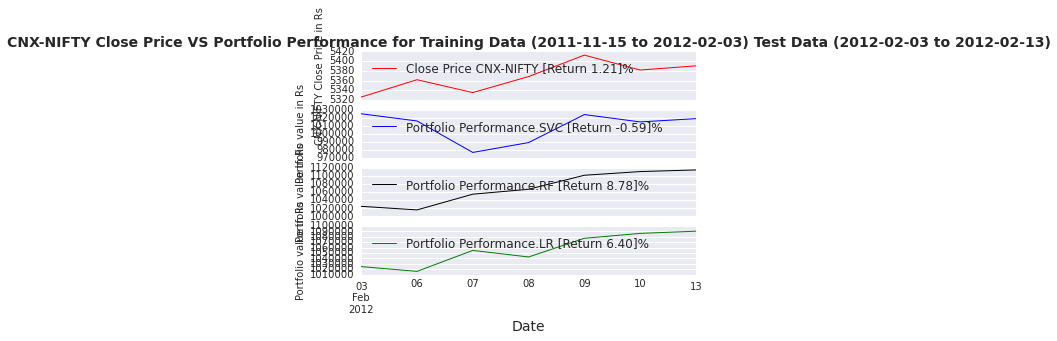

Shape of merged data (44, 40) .
After merge out of [ 1760 ] [ 120 ] data points are missing.
Number of NaN after time interpolation: 80
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
-1    19
 1    16
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
-1    6
 1    3
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.666666666667
Accuracy for SVM Classifier 0.555555555556
Accuracy for KNN Classifier 0.666666666667
Accuracy for RF Classifier 0.888888888889
Best Parameter SVC {'C': 1, 'kernel': 'linear'}
Accuracy for SVM Classifier 0.666666666667
Accuracy for SVM Classifier 0.555555555556
Benchmark Return [0.41]%
LR        Return [2.56]%
SVC       Return [1.22]%
RF        Return [3.68]%


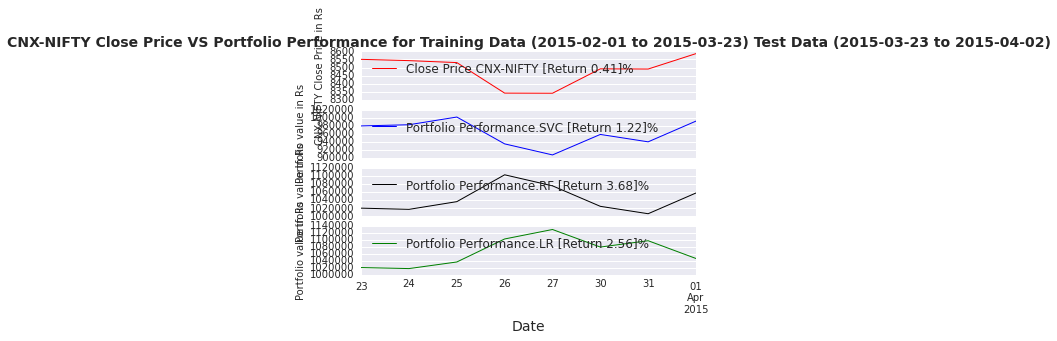

Shape of merged data (43, 40) .
After merge out of [ 1720 ] [ 112 ] data points are missing.
Number of NaN after time interpolation: 92
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
-1    19
 1    12
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
 1    9
-1    3
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.833333333333
Accuracy for SVM Classifier 0.833333333333
Accuracy for KNN Classifier 0.25
Accuracy for RF Classifier 0.583333333333
Best Parameter SVC {'C': 1, 'kernel': 'rbf'}
Accuracy for SVM Classifier 0.25
Accuracy for SVM Classifier 0.833333333333
Benchmark Return [4.42]%
LR        Return [4.89]%
SVC       Return [-18.60]%
RF        Return [16.13]%


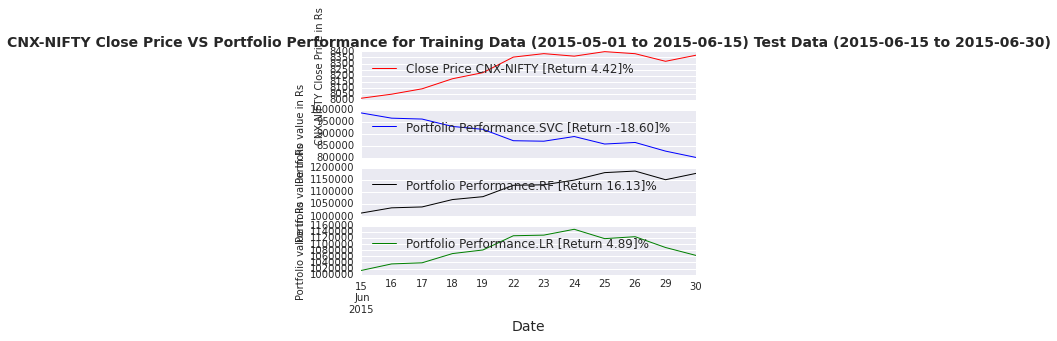

Shape of merged data (45, 40) .
After merge out of [ 1800 ] [ 104 ] data points are missing.
Number of NaN after time interpolation: 82
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
 1    18
-1    15
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
-1    6
 1    6
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 1.0
Accuracy for SVM Classifier 1.0
Accuracy for KNN Classifier 0.666666666667
Accuracy for RF Classifier 1.0
Best Parameter SVC {'C': 1, 'kernel': 'linear'}
Accuracy for SVM Classifier 0.5
Accuracy for SVM Classifier 1.0
Benchmark Return [-0.87]%
LR        Return [27.98]%
SVC       Return [27.98]%
RF        Return [27.98]%


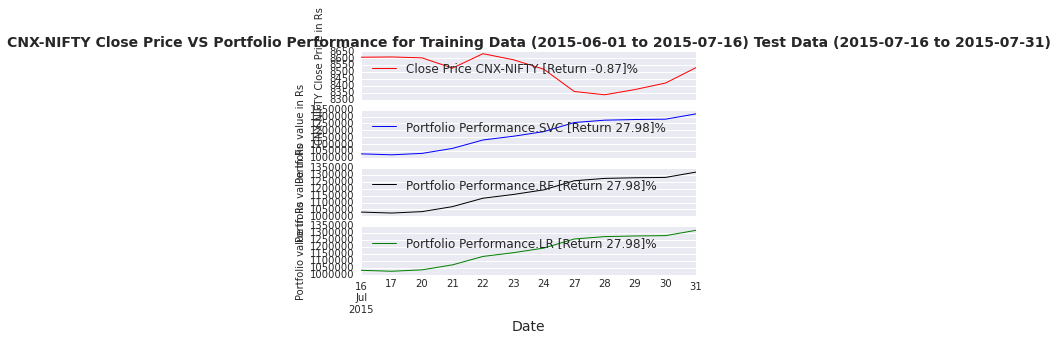

Shape of merged data (43, 40) .
After merge out of [ 1720 ] [ 96 ] data points are missing.
Number of NaN after time interpolation: 88
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
-1    17
 1    16
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
-1    6
 1    4
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.4
Accuracy for SVM Classifier 0.6
Accuracy for KNN Classifier 0.8
Accuracy for RF Classifier 0.7
Best Parameter SVC {'C': 1, 'kernel': 'linear'}
Accuracy for SVM Classifier 0.6
Accuracy for SVM Classifier 0.6
Benchmark Return [-5.61]%
LR        Return [15.32]%
SVC       Return [25.98]%
RF        Return [21.99]%


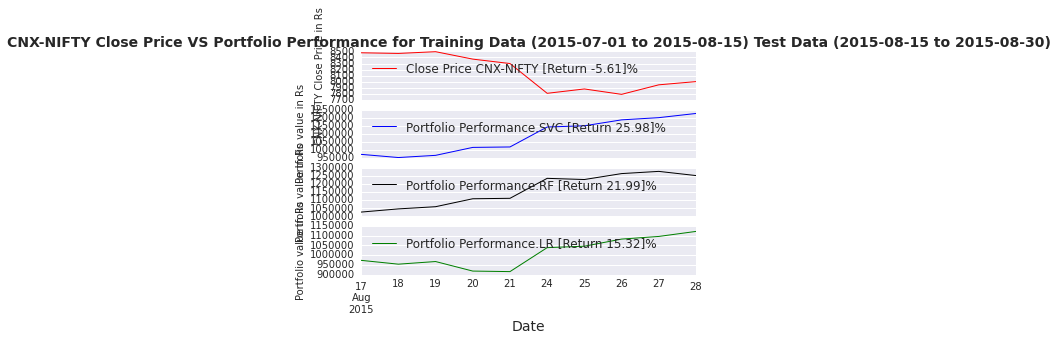

Shape of merged data (43, 40) .
After merge out of [ 1720 ] [ 152 ] data points are missing.
Number of NaN after time interpolation: 80
Number of NaN after mean interpolation: 0
Positive and negative movement in train data outcome.
-1    18
 1    13
Name: UpDown, dtype: int64
Positive and negative movement in test data outcome.
 1    7
-1    5
Name: UpDown, dtype: int64
Accuracy for Logistic Classifier 0.5
Accuracy for SVM Classifier 0.916666666667
Accuracy for KNN Classifier 0.5
Accuracy for RF Classifier 1.0
Best Parameter SVC {'C': 1, 'kernel': 'rbf'}
Accuracy for SVM Classifier 0.416666666667
Accuracy for SVM Classifier 0.916666666667
Benchmark Return [1.53]%
LR        Return [9.15]%
SVC       Return [-3.60]%
RF        Return [2.41]%


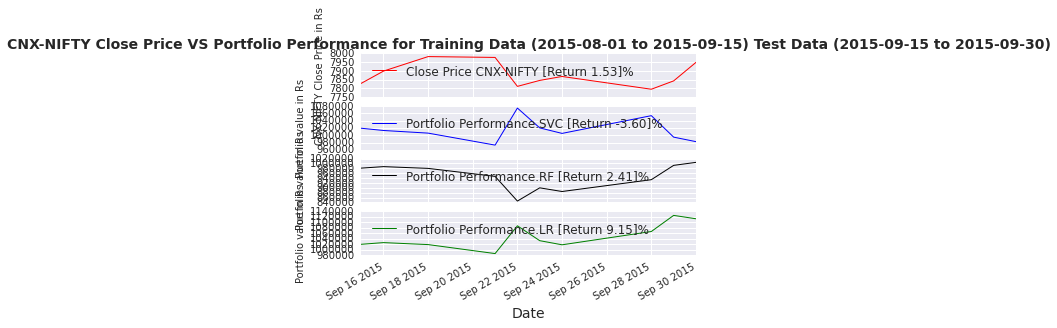

Training Data from (2014-01-01 to 2014-11-27) Test Data (2014-11-27 to 2015-03-27) Benchmark Return [-1.80]%  LR Return [78.00]% SVC Return [-6.27]% RF Return [58.53]%
Training Data from (2012-01-01 to 2012-02-15) Test Data (2012-02-15 to 2012-03-01) Benchmark Return [-3.47]%  LR Return [-13.78]% SVC Return [-13.78]% RF Return [21.93]%
Training Data from (2013-05-01 to 2013-06-15) Test Data (2013-06-15 to 2013-06-30) Benchmark Return [-0.13]%  LR Return [-0.02]% SVC Return [-0.02]% RF Return [28.66]%
Training Data from (2015-07-01 to 2015-09-14) Test Data (2015-09-14 to 2015-09-29) Benchmark Return [-0.37]%  LR Return [0.73]% SVC Return [0.73]% RF Return [-0.76]%
Training Data from (2010-02-01 to 2010-04-02) Test Data (2010-04-02 to 2010-04-17) Benchmark Return [-1.97]%  LR Return [5.20]% SVC Return [-7.82]% RF Return [-2.45]%
Training Data from (2011-11-15 to 2012-02-03) Test Data (2012-02-03 to 2012-02-13) Benchmark Return [1.21]%  LR Return [6.40]% SVC Return [-0.59]% RF Return [8.7

In [84]:
final_result=''

for start_date,e,s in zip(start_date_list, end_date_list, start_test_list):
    end_date, start_test = get_date(start_date, e,s)
    d = DataHandler()
    data_frames = d.fetch_and_save_data(indices, market_name, start_date, end_date)

    for data_frame in data_frames:
        d.daily_return(data_frame)

    dp = DataProcessor()

    data_points = [4, 6, 8]

    # Compute moving average
    for data_frame in data_frames:
        data_frame = dp.get_moving_average(data_frame, data_points)

    #Compute exponential moving average
    for data_frame in data_frames:
        data_frame = dp.get_ewma(data_frame, data_points)

    renamme_columns(data_frames, market_name)
    
    merged_data = merge_data_frames(data_frames, 5)
    
    
    merged_data.Return_CNX_NIFTY = merged_data['Daily Return_nse'].shift(-1)

    
    print("Shape of merged data", merged_data.shape, ".")
    print("After merge out of [", len(merged_data) * len(merged_data.columns), "] [", count_missing(merged_data),
          "] data points are missing.")

    merged_data = merged_data.interpolate(method='time')
    print('Number of NaN after time interpolation: %s' % str(count_missing(merged_data)))

    merged_data = merged_data.fillna(merged_data.mean())
    print('Number of NaN after mean interpolation: %s' % count_missing(merged_data))

    
    X_train, y_train, X_test, y_test = dp.prepare_data_for_classification(merged_data, start_test)

    print("Positive and negative movement in train data outcome.")
    print(y_train.value_counts())
    print("Positive and negative movement in test data outcome.")
    print(y_test.value_counts())

    dp.apply_logistic_regressor(X_train, y_train, X_test, y_test)
    dp.apply_svc(X_train, y_train, X_test, y_test)
    dp.apply_knn(X_train, y_train, X_test, y_test)
    dp.apply_random_forest(X_train, y_train, X_test, y_test)

    parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10, 100, 1000]}
    bp=dp.select_best_param_svc(X_train, y_train, parameters)
    dp.apply_svc(X_train, y_train, X_test, y_test, kernel='rbf', C=1)
    dp.apply_svc(X_train, y_train, X_test, y_test, kernel='linear', C=1)


    symbol = 'CNX-NIFTY'
    bars = d.fetch_data_from_yahoo('^NSEI', start_test, end_date)

    X_train, y_train, X_test, y_test = dp.partition_data(merged_data, len(bars))

    predict_svc = dp.get_svc_prediction(X_train, y_train, X_test, kernel=bp['kernel'], C=bp['C'])
    signals_svc = pd.DataFrame(index=bars.index)
    signals_svc['signal'] = 0.0
    signals_svc['signal'] = predict_svc
    signals_svc['positions'] = signals_svc['signal'].diff()
    portfolio_svc = MarketIntradayPortfolio(symbol, bars, signals_svc)
    returns_svc = portfolio_svc.backtest_portfolio()


    predict_rf = dp.get_randomforest_prediction(X_train, y_train, X_test, 100)
    signals_rf = pd.DataFrame(index=bars.index)
    signals_rf['signal'] = 0.0
    signals_rf['signal'] = predict_rf
    signals_rf['positions'] = signals_rf['signal'].diff()


    portfolio_rf = MarketIntradayPortfolio(symbol, bars, signals_rf)
    returns_rf = portfolio_rf.backtest_portfolio()

    predict_lr = dp.get_logistic_reg_prediction(X_train, y_train, X_test)
    signals_lr = pd.DataFrame(index=bars.index)
    signals_lr['signal'] = 0.0
    signals_lr['signal'] = predict_lr
    signals_lr['positions'] = signals_lr['signal'].diff()
    portfolio_lr = MarketIntradayPortfolio(symbol, bars, signals_lr)
    returns_lr = portfolio_lr.backtest_portfolio()

    bench_ret=(bars['Close'][-1]-bars['Close'][0])*100/bars['Close'][0]
    lr_ret=(returns_lr['total'][-1]-returns_lr['total'][0])*100/returns_lr['total'][0]
    svc_ret=(returns_svc['total'][-1]-returns_svc['total'][0])*100/returns_svc['total'][0]
    rf_ret=(returns_rf['total'][-1]-returns_rf['total'][0])*100/returns_rf['total'][0]


    f, ax = plt.subplots(4, sharex=True)
    f.patch.set_facecolor('white')
    ylabel = symbol + ' Close Price in Rs'
    bars['Close'].plot(ax=ax[0], color='r', lw=1.)
    ax[0].set_ylabel(ylabel, fontsize=10)
    ax[0].set_xlabel('', fontsize=14)
    ax[0].legend(('Close Price CNX-NIFTY [Return %.2f]%%'%bench_ret,), loc='upper left', prop={"size": 12})
    ax[0].set_title('CNX-NIFTY Close Price VS Portfolio Performance for Training Data ('+start_date+' to '
                    +start_test+') Test Data ('
                    +start_test+' to '+end_date+')', fontsize=14,
                    fontweight="bold")

    returns_svc['total'].plot(ax=ax[1], color='b', lw=1.)
    ax[1].set_ylabel('Portfolio value in Rs', fontsize=10)
    ax[1].set_xlabel('Date', fontsize=14)
    ax[1].legend(('Portfolio Performance.SVC [Return %.2f]%%'%svc_ret,), loc='upper left', prop={"size": 12})
    plt.tick_params(axis='both', which='major', labelsize=10)

    returns_rf['total'].plot(ax=ax[2], color='k', lw=1.)
    ax[2].set_ylabel('Portfolio value in Rs', fontsize=10)
    ax[2].set_xlabel('Date', fontsize=14)
    ax[2].legend(('Portfolio Performance.RF [Return %.2f]%%'%rf_ret,), loc='upper left', prop={"size": 12})
    plt.tick_params(axis='both', which='major', labelsize=10)

    returns_lr['total'].plot(ax=ax[3], color='g', lw=1.)
    ax[3].set_ylabel('Portfolio value in Rs', fontsize=10)
    ax[3].set_xlabel('Date', fontsize=14)
    ax[3].legend(('Portfolio Performance.LR [Return %.2f]%%'%lr_ret,), loc='upper left', prop={"size": 12})
    plt.tick_params(axis='both', which='major', labelsize=10)


    print("Benchmark Return [%.2f]%%" %(bench_ret))
    print("LR        Return [%.2f]%%" %(lr_ret))
    print("SVC       Return [%.2f]%%" %(svc_ret))
    print("RF        Return [%.2f]%%" %(rf_ret))
    
    final_result +='Training Data from (' + start_date +' to '+ start_test + ') Test Data (' + start_test +' to ' + end_date + ') Benchmark Return [%.2f]%% ' %(bench_ret) +" LR Return [%.2f]%%" %(lr_ret)+" SVC Return [%.2f]%%" %(svc_ret) +" RF Return [%.2f]%%" %(rf_ret)+'\n'
    
    plt.show()

print(final_result)
